---

# Initialization

### Imports

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from LRFutils import archive, progress
from src import plot
from scipy.special import wofz
from multiprocess import Pool, cpu_count
import os
import pyvtk as vtk
import psutil
from astropy import units as u
from astropy.constants import h, k_B as k, c

### Constants

In [70]:
T = 10 * u.K
pi = np.pi

### Class definitions

In [71]:
class Gas:
    def __init__(
            self,
            f=None,
            profile=None,
            density_cube=None,
            velocity_cube=None,
            v0=None,
            sigma_v=None,
            A12=None,
            B12=None,
            B21=None,
            emissivity=None,
            absorption=None,

        ):
        self.f = f
        self.profile = profile
        self.density_cube = density_cube
        self.velocity_cube = velocity_cube
        self.v0 = v0
        self.sigma_v = sigma_v
        self.A12 = A12
        self.B12 = B12
        self.B21 = B21
        self.emissivity = emissivity
        self.absorption = absorption

    @property
    def n_ratio(self):
        return 1/np.exp(-h*self.v0 / (k*T))

    @property
    def n1(self):
        return self.density_cube - self.density_cube / (self.n_ratio + 1)
    
    @property
    def n2(self):
        return self.density_cube / (self.n_ratio + 1)

### Functions definitions

In [72]:
def gaussian(x, m=0.5, s=0.05):
    return np.exp(- (x - m)**2 / (2 * s**2))

def lorentzian(x, mu, gamma):
    return gamma / (np.pi * ((x - mu)**2 + gamma**2))

def plummer(r, R=0.75):
    return 3/(4*np.pi*R**3)*(1 + r**2 / R**2)**(-5/2)

def voigt_profile(freq_range, sigma, gamma):
    x = freq_range
    y = np.zeros_like(x)
    for i, x_i in enumerate(x):
        z = (x_i + 1j * gamma) / (sigma * np.sqrt(2))
        y[i] = np.real(wofz(z)) / (sigma * np.sqrt(2*np.pi))
    return y

def sigmoid(x, d=0.5, l=10):
    return 1/(1+np.exp(-l*(x-d)))

def black_body(f, T):
    return 2 * h * f**3 / c**2 / (np.exp(h * f / k / T) - 1)

def system_info():
    return f"CPU: {psutil.cpu_percent()}%"\
        + f", RAM: {psutil.virtual_memory().percent}%"\
        + f" ({psutil.virtual_memory().used/1024**3:.2f}GB"\
        + f"/ {psutil.virtual_memory().total/1024**3:.2f}GB)"

### Configuration

In [73]:
nb_simu = 1000 # number of generated simulations
# ⚠️ Be carefull, the final dataset will be proportional to nb_images = 6 * nb_simu

# Global
N = 64 # resolution in pixel
r, dr = np.linspace(-1, 1, N, endpoint=True, retstep=True)
r = r * u.pc
dr = dr * u.pc

# Plummer profile (density)
plummer_radius = 0.5 * u.pc
max_density = 1e6 / u.cm**3 # hydrogen abundance

CO_fractional_abundance = 1e-4 # particle / hydrogen atom
N2H_fractional_abundance = 1e-7 # particle / hydrogen atom

# Sigmoid parameters (repartition of the gas)
sigmoid_treshold = max_density/2
sigmoid_slope = 50/max_density

# CO
CO = Gas()
CO.v0 = 115.27120e9 * u.Hz
CO.sigma_v = 384233 * u.Hz
CO.f = np.linspace(CO.v0 - 10*u.Hz, CO.v0 + 10*u.Hz, N)
CO.profile = gaussian(CO.f, CO.v0, CO.sigma_v)
CO.A21 = 7.203e-8 / u.s
CO.B21 = 2.574e-6 * u.cm**2 / u.erg / u.s
CO.B12 = 2.713e-6 * u.cm**2 / u.erg / u.s

print("n1/n2 for CO:", CO.n_ratio)

# N2H+
N2H = Gas()
N2H.v0 = 93.17371e9 * u.Hz
N2H.sigma_v = 1 * u.Hz
N2H.f = np.linspace(N2H.v0 - 10*u.Hz, N2H.v0 + 10*u.Hz, N)
N2H.profile = gaussian(N2H.f, N2H.v0, N2H.sigma_v)
N2H.A21 = 3.929e-5 / u.s
N2H.B21 = 1.226e-5 * u.cm**2 / u.erg / u.s
N2H.B12 = 2.832e-5 * u.cm**2 / u.erg / u.s

print("n1/n2 for N2H+:", N2H.n_ratio)

n1/n2 for CO: 1.7388335383432474
n1/n2 for N2H+: 1.5638696307288826


### Verification

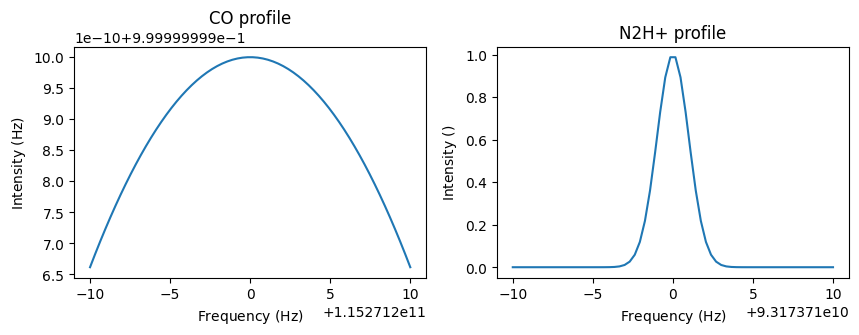

In [74]:
plt.figure(figsize=(10, 3))
plt.subplot(121)
plt.plot(CO.f, CO.profile)
plt.title("CO profile")
plt.xlabel(f"Frequency ({CO.f.unit.to_string('latex')})")
plt.ylabel(f"Intensity ({CO.f.unit.to_string('latex')})")
plt.subplot(122)
plt.plot(N2H.f, N2H.profile)
plt.title("N2H+ profile")
plt.xlabel(f"Frequency ({N2H.f.unit.to_string('latex')})")    
plt.ylabel(f"Intensity ({N2H.profile.unit.to_string('latex')})")
plt.show()

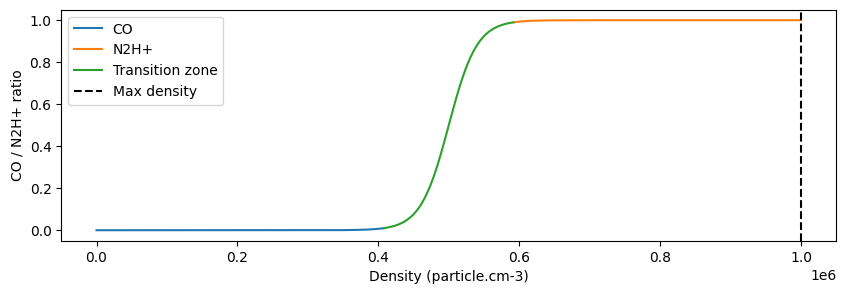

In [75]:
plt.figure(figsize=(10, 3))
tmp = max(max_density, 2*sigmoid_treshold)
tmp = np.linspace(0, tmp, 1000)
print((sigmoid_treshold*sigmoid_slope).unit)
tmp2 = sigmoid(tmp, sigmoid_treshold, sigmoid_slope)
plt.plot(tmp[tmp2 < 0.01], tmp2[tmp2 < 0.01], label="CO")
plt.plot(tmp[tmp2 > 0.99], tmp2[tmp2 > 0.99], label="N2H+")
plt.plot(tmp[(tmp2 > 0.01) & (tmp2 < 0.99)], tmp2[(tmp2 > 0.01) & (tmp2 < 0.99)], label="Transition zone")
plt.axvline(max_density.value, color="k", linestyle="--", label="Max density")
plt.xlabel("Density (particle.cm-3)")
plt.ylabel("CO / N2H+ ratio")
plt.legend()
plt.show()

### Environment variables

In [76]:
X, Y, Z = np.meshgrid(r, r, r)
R = np.sqrt(X**2 + Y**2 + Z**2)

archive_path = archive.new("Generation", verbose=True)

try:
    ncpu = cpu_count()
except:
    with open(os.getenv("OAR_NODEFILE"), 'r') as f:
        ncpu = len(f.readlines())

Archive created at ./archives/2023-03-07_77566e4/4_Generation


---

# Cloud density generation

In [77]:
p = plummer(R, plummer_radius)
H = Gas()
H.density_cube = max_density * p / np.max(p)
CO.density_cube = H.density_cube * (1 - sigmoid(H.density_cube, sigmoid_treshold, sigmoid_slope))
CO. density_cube = CO_fractional_abundance * CO.density_cube * np.max(H.density_cube) / np.max(CO.density_cube)
N2H.density_cube = H.density_cube * sigmoid(H.density_cube, sigmoid_treshold, sigmoid_slope)
N2H. density_cube = N2H_fractional_abundance * N2H.density_cube * np.max(H.density_cube) / np.max(N2H.density_cube)

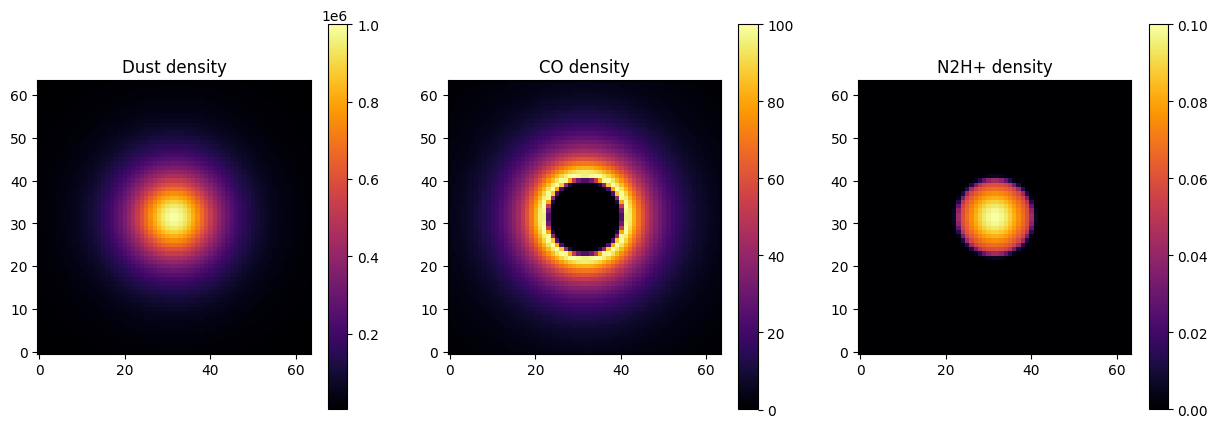

In [78]:
plt.figure(figsize=(15, 5))
plt.subplot(131)    
im = plt.imshow(H.density_cube[N//2].value, origin="lower", cmap="inferno")
plt.colorbar(im)
plt.title("Dust density")
plt.subplot(132)
im = plt.imshow(CO.density_cube[N//2].value, origin="lower", cmap="inferno")
plt.colorbar(im)
plt.title("CO density")
plt.subplot(133)
im = plt.imshow(N2H.density_cube[N//2].value, origin="lower", cmap="inferno")
plt.colorbar(im)
plt.title("N2H+ density")
plt.show()

In [79]:
plt.figure(figsize=(15, 5))
plt.subplot(131)    
im = plt.imshow((np.sum(H.density_cube, axis=0) * dr.to(u.cm)).value, origin="lower", cmap="inferno")
plt.colorbar(im)
plt.title("Dust density")
plt.subplot(132)
im = plt.imshow((np.sum(CO.density_cube, axis=0) * dr.to(u.cm)).value, origin="lower", cmap="inferno")
plt.colorbar(im)
plt.title("CO density")
plt.subplot(133)
im = plt.imshow((np.sum(N2H.density_cube, axis=0) * dr.to(u.cm)).value, origin="lower", cmap="inferno")
plt.colorbar(im)
plt.title("N2H+ density")
plt.show()

UnitConversionError: Can only apply 'greater' function to dimensionless quantities when other argument is not a quantity (unless the latter is all zero/infinity/nan).

<Figure size 1500x500 with 6 Axes>

---

# Cloud velocity generation

In [ ]:
CO.velocity_cube = np.zeros((N, N, N))
N2H.velocity_cube = np.zeros((N, N, N))

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
im = plt.imshow(CO.velocity_cube[N//2], origin="lower", cmap="seismic_r")
plt.colorbar(im)
plt.title("CO velocity")
plt.subplot(122)
im = plt.imshow(N2H.velocity_cube[N//2], origin="lower", cmap="seismic_r")
plt.colorbar(im)
plt.title("N2H+ velocity")
plt.show()

---

# Radiative transfer

### Emmissivity and absorption

In [ ]:
for gas in [CO, N2H]:
    gas.emissivity_hypercube = np.zeros((N, N, N, len(gas.f)))
    gas.absorption_hypercube = np.zeros((N, N, N, len(gas.f)))

    for f in range(len(gas.f)):
        gas.absorption_hypercube[:,:,:,f] = h * gas.v0 / (4 * pi) * (gas.n1 * gas.B12 - gas.n2 * gas.B21) * gas.profile[f]
        gas.emissivity_hypercube[:,:,:,f] = h * gas.v0 / (4 * pi) * (gas.A21 * gas.n2) * gas.profile[f]

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(CO.f, CO.emissivity_hypercube[N//2,N//2,N//2,:], label="Emissivity")
plt.plot(CO.f, CO.absorption_hypercube[N//2,N//2,N//2,:], label="Absorption")
plt.title("CO (at the center of the cloud)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Intensity (arb. unit)")
plt.legend()
plt.subplot(122)
plt.plot(N2H.f, N2H.emissivity_hypercube[N//2,N//2,N//2,:], label="Emissivity")
plt.plot(N2H.f, N2H.absorption_hypercube[N//2,N//2,N//2,:], label="Absorption")
plt.title("N2H+ (at the center of the cloud)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Intensity (arb. unit)")
plt.legend()
plt.show()


In [ ]:
dN = dr * 3.0857E+18 # parsec to cm

for gas in [CO, N2H]:

    kappa = gas.absorption_hypercube
    epsilon = gas.emissivity_hypercube
    print("Epsilon min and max:", np.amin(epsilon), np.amax(epsilon))
    print("Kappa min and max:", np.amin(kappa), np.amax(kappa))

    # Integrating the equation of radiative transfer
    gas.observation = np.zeros((N, N, len(gas.f)))
    
    fig, axs = plt.subplots(6, 11, figsize=(25, 10))
    cpt = 0
    axs[0,0].set_ylabel(r"$\kappa_\nu \Delta n$")
    axs[1,0].set_ylabel(r"$\tau_\nu(s' \rightarrow S)$")
    axs[2,0].set_ylabel(r"$e^{-\tau_\nu(s' \rightarrow S)}$")
    axs[3,0].set_ylabel(r"$\epsilon_\nu e^{-\tau_\nu(s' \rightarrow S)}\Delta n$")
    axs[4,0].set_ylabel(r"$I_\nu(S)$")

    im = axs[5, cpt].imshow(np.sum(H.density_cube, axis=0) * dN, origin="lower", cmap="inferno")
    plt.colorbar(im)

    for i in range(0,N):

        # Computing Tau_s
        tau = np.zeros((N, N, len(gas.f)))
        for j in np.arange(i, N):
            tau += kappa[j] * dN

        layer_contrib = epsilon[i] * np.exp(-tau) * dN
        gas.observation += layer_contrib

        if i % (N//10) == 0:
            im = axs[0, cpt].imshow(kappa[i][:,:,N//2] * dN, origin="lower", cmap="inferno")
            plt.colorbar(im)
            im = axs[1, cpt].imshow(tau[:,:,N//2], origin="lower")
            plt.colorbar(im)
            im = axs[2, cpt].imshow(np.exp(-tau)[:,:,N//2], origin="lower", cmap="gray")
            plt.colorbar(im)
            im = axs[3, cpt].imshow(layer_contrib[:,:,N//2], origin="lower", cmap="inferno")
            plt.colorbar(im)
            im = axs[4, cpt].imshow(gas.observation[:,:,N//2], origin="lower", cmap="inferno")
            plt.colorbar(im)
            cpt += 1

In [ ]:
# Computing Tau_s
tau_s = np.zeros((N, N, len(gas.f)))
for Np in range(N):
    tau_s += CO.absorption_hypercube[Np] * dr * 3.0857E+18 # parsec to cm

plt.figure(figsize=(10, 10))
plt.imshow(tau_s[:,:,N//2], origin="lower")
plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.imshow(CO.observation[:,:,N//2], origin="lower", cmap="inferno")
plt.colorbar()
plt.title("CO observation")
plt.subplot(222)
plt.plot(CO.f, CO.observation[N//2,N//2,:])
plt.title("CO spectrum (at the center of the cloud)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Intensity (erg)")
plt.subplot(223)
plt.imshow(N2H.observation[:,:,N//2], origin="lower", cmap="inferno")
plt.colorbar()
plt.title("N2H+ observation")
plt.subplot(224)    
plt.plot(N2H.f, N2H.observation[N//2,N//2,:])
plt.title("N2H+ spectrum (at the center of the cloud)")
plt.xlabel("Frequency (Hz)")    
plt.ylabel("Intensity (erg)")
plt.show()

---

# Save data as LOC inputs

Follwing the [LOC documentation](interstellarmedium.org/radiative_transfer/loc/)

In [ ]:
# Model cloud description

header = np.array([N, N, N,], dtype=np.int32)
model = np.zeros((N, N, N, 7), dtype=np.float32)

model[:,:,:,0] = H.density_cube # cloud density
model[:,:,:,1] = T # kinetic temperature
model[:,:,:,2] = 0 # microturbulence
model[:,:,:,3] = 0 # macroscopic velocity (x)
model[:,:,:,4] = 0 # macroscopic velocity (y)
model[:,:,:,5] = 0 # macroscopic velocity (z)
model[:,:,:,6] = CO_fractional_abundance # fractional abundance

with open("rsrc/LOC/input_cloud_CO.bin", "wb") as file:
    header.tofile(file)
    model.tofile(file)

In [ ]:
# Initialisation file

config = f"""\
cloud          input_cloud_CO.bin        #  cloud defined on a Cartesian grid
distance       7200.0           #  cloud distance [pc]
angle          1.0             #  model cell size  [arcsec]
molecule       input_molecule_CO.dat          #  name of the Lamda file
density        1.0           #  scaling of densities in the cloud file
temperature    1.0             #  scaling of Tkin values in the cloud file
fraction       1.0e-4           #  scaling o the fraction abundances
velocity       1.0             #  scaling of the velocity
sigma          1.0             #  scaling o the microturbulence
isotropic      2.73            #  Tbg for the background radiation field
levels         3              #  number of energy levels in the calculations
uppermost      3               #  uppermost level tracked for convergence
iterations     5               #  number of iterations
nside          2               #  NSIDE parameter determining the number of rays (angles)
direction      90 0.001        #  theta, phi [deg] for the direction towards the observer
points         64 64           #  number of pixels in the output maps
grid           1.0             #  map pixel size [arcsec]
spectra        1 0  2 1        #  spectra written for transitions == upper lower (pair of integers)
transitions    1 0  2 1        #  Tex saved for transitions (upper and lower levels of each transition)
bandwidth      6.0             #  bandwidth in the calculations [km/s]
channels       128             #  number of velocity channels
prefix         output          #  prefix for output files
load           load_level_pop       #  load level populations
save           save_level_pop       #  save level populations
stop          -1.0             #  stop if level-populations change below a threshold
gpu            1               #  gpu>0 => use the first available gpu
"""

with open("rsrc/LOC/input_config_CO.ini", "w") as file:
    file.write(config)